# ATO & ATC & intraday prices relationship - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-09-30 14:15:00,1353.1,1353.9,1351.5,1353.1,6265
2024-09-30 14:20:00,1353.0,1354.7,1352.6,1354.6,4426
2024-09-30 14:25:00,1354.6,1356.3,1354.1,1355.9,7920


In [6]:
data['ibs'] = data.apply(lambda x: (0 if (x["High"] == x["Low"]) else round((x["Close"] - x["Low"]) / (x["High"] - x["Low"]), 1)), axis=1)

In [7]:
def get_data_13h00(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1300]
  if not tick.empty:
    return tick[0]

def cal_close_14h25(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1425]
  if not tick.empty:
    return tick[0]

In [9]:
day_data = data.copy()
day_data['ATO_ibs'] = day_data['ibs']
day_data['_1pm_ibs'] = day_data['ibs']
day_data['close_14h25'] = day_data['Close']
day_data = day_data.resample('D').agg({
        'Volume': 'sum',
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'ATO_ibs': 'first',
        '_1pm_ibs': get_data_13h00,
        'close_14h25': cal_close_14h25    
    })
day_data.dropna(subset=['Close'], inplace=True)

In [10]:
day_data['return'] = day_data['Close'] - day_data['close_14h25']

In [11]:
day_data

,Volume,Open,Close,High,Low,ATO_ibs,_1pm_ibs,close_14h25,return
Date,,,,,,,,,
2020-11-02,132589,900.1,904.0,907.0,895.4,0.9,0.4,907.0,-3.0
2020-11-03,116107,909.3,908.3,910.8,903.7,0.3,0.3,908.5,-0.2
2020-11-04,124814,909.0,912.3,918.1,906.7,0.1,0.3,913.5,-1.2
2020-11-05,130341,913.7,910.2,919.9,910.0,0.0,0.4,910.8,-0.6
2020-11-06,110492,911.2,908.3,912.7,903.3,0.9,0.8,910.0,-1.7
...,...,...,...,...,...,...,...,...,...
2024-09-24,165206,1326.0,1335.0,1335.1,1322.2,0.0,0.8,1335.1,-0.1
2024-09-25,181546,1337.3,1344.0,1349.9,1336.9,0.4,0.5,1344.4,-0.4
2024-09-26,224658,1345.9,1356.4,1366.5,1345.2,0.9,0.0,1358.6,-2.2


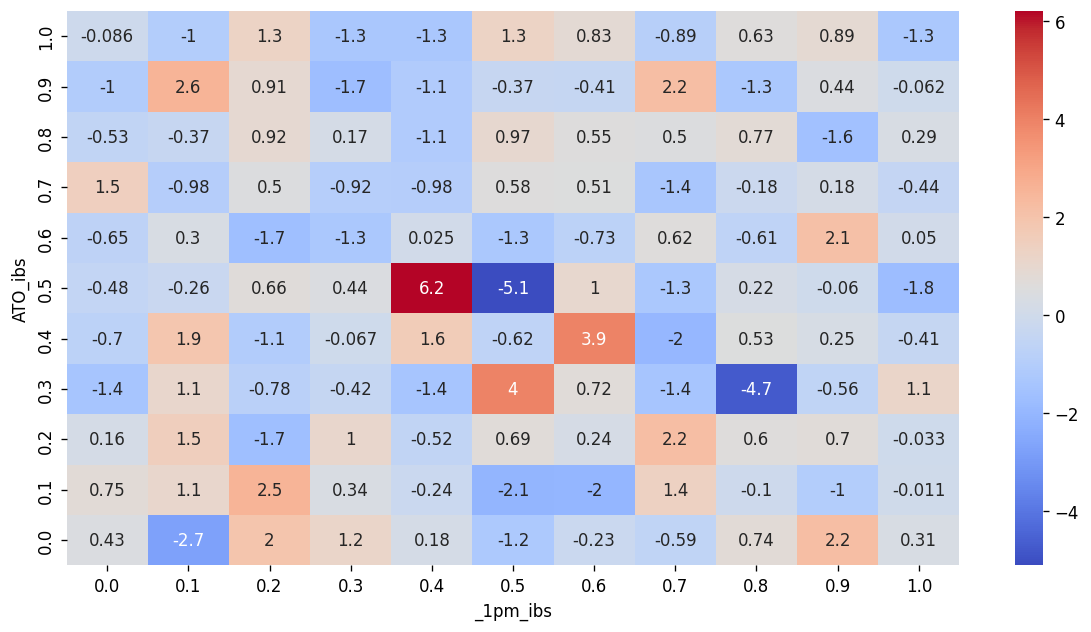

In [12]:
grpd = day_data.groupby(['ATO_ibs', '_1pm_ibs'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='ATO_ibs', columns='_1pm_ibs', values='return').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

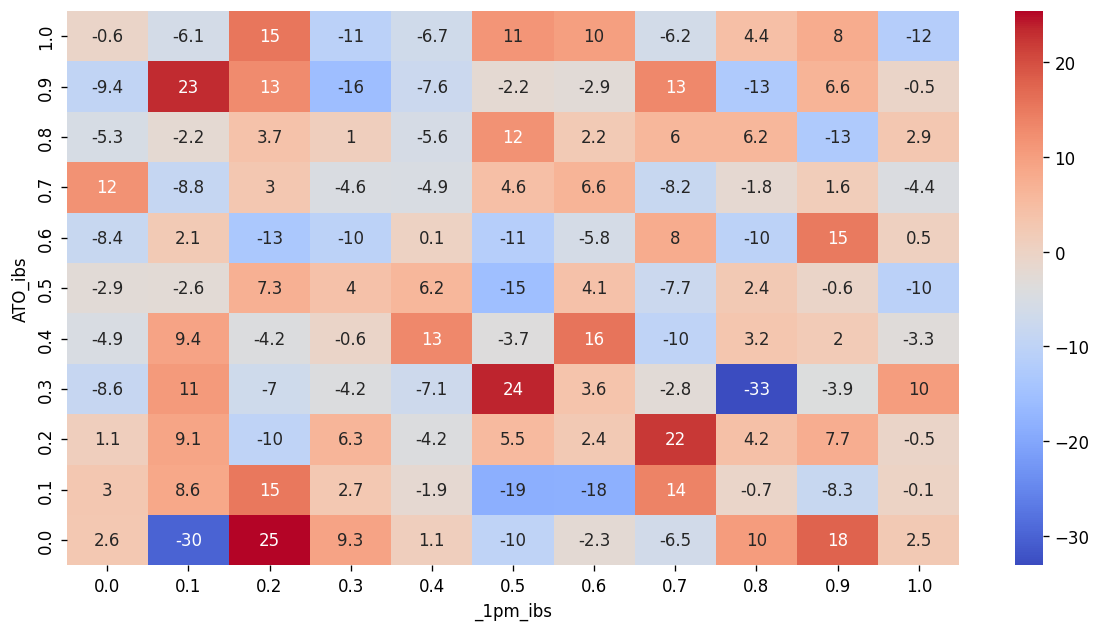

In [13]:
irs_sum = grpd.sum().reset_index()
sns.heatmap(
    irs_sum.pivot(index='ATO_ibs', columns='_1pm_ibs', values='return').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);